# Amir Mohammad Ebrahiminasab - 610301101 - AIProject

---

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirebrahiminasab","key":"f5ea3a6c93484c7a343c4382559fb1c5"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 97% 695M/714M [00:05<00:00, 140MB/s]
100% 714M/714M [00:05<00:00, 139MB/s]


In [5]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [6]:
import tensorflow as tf
import tifffile
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Metric
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from transformers import AutoModel
import timm
import torch.optim as optim
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Dropout,
    Lambda,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    concatenate,
    UpSampling2D,
)
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

## 1. Dataset Familiarization

In [ ]:
mask_files = glob.glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_dataset = []

for i in mask_files:
    image_dataset.append(i.replace('_mask', ''))

In [ ]:
print(f'{len(image_dataset)} {len(mask_files)}')

3929 3929


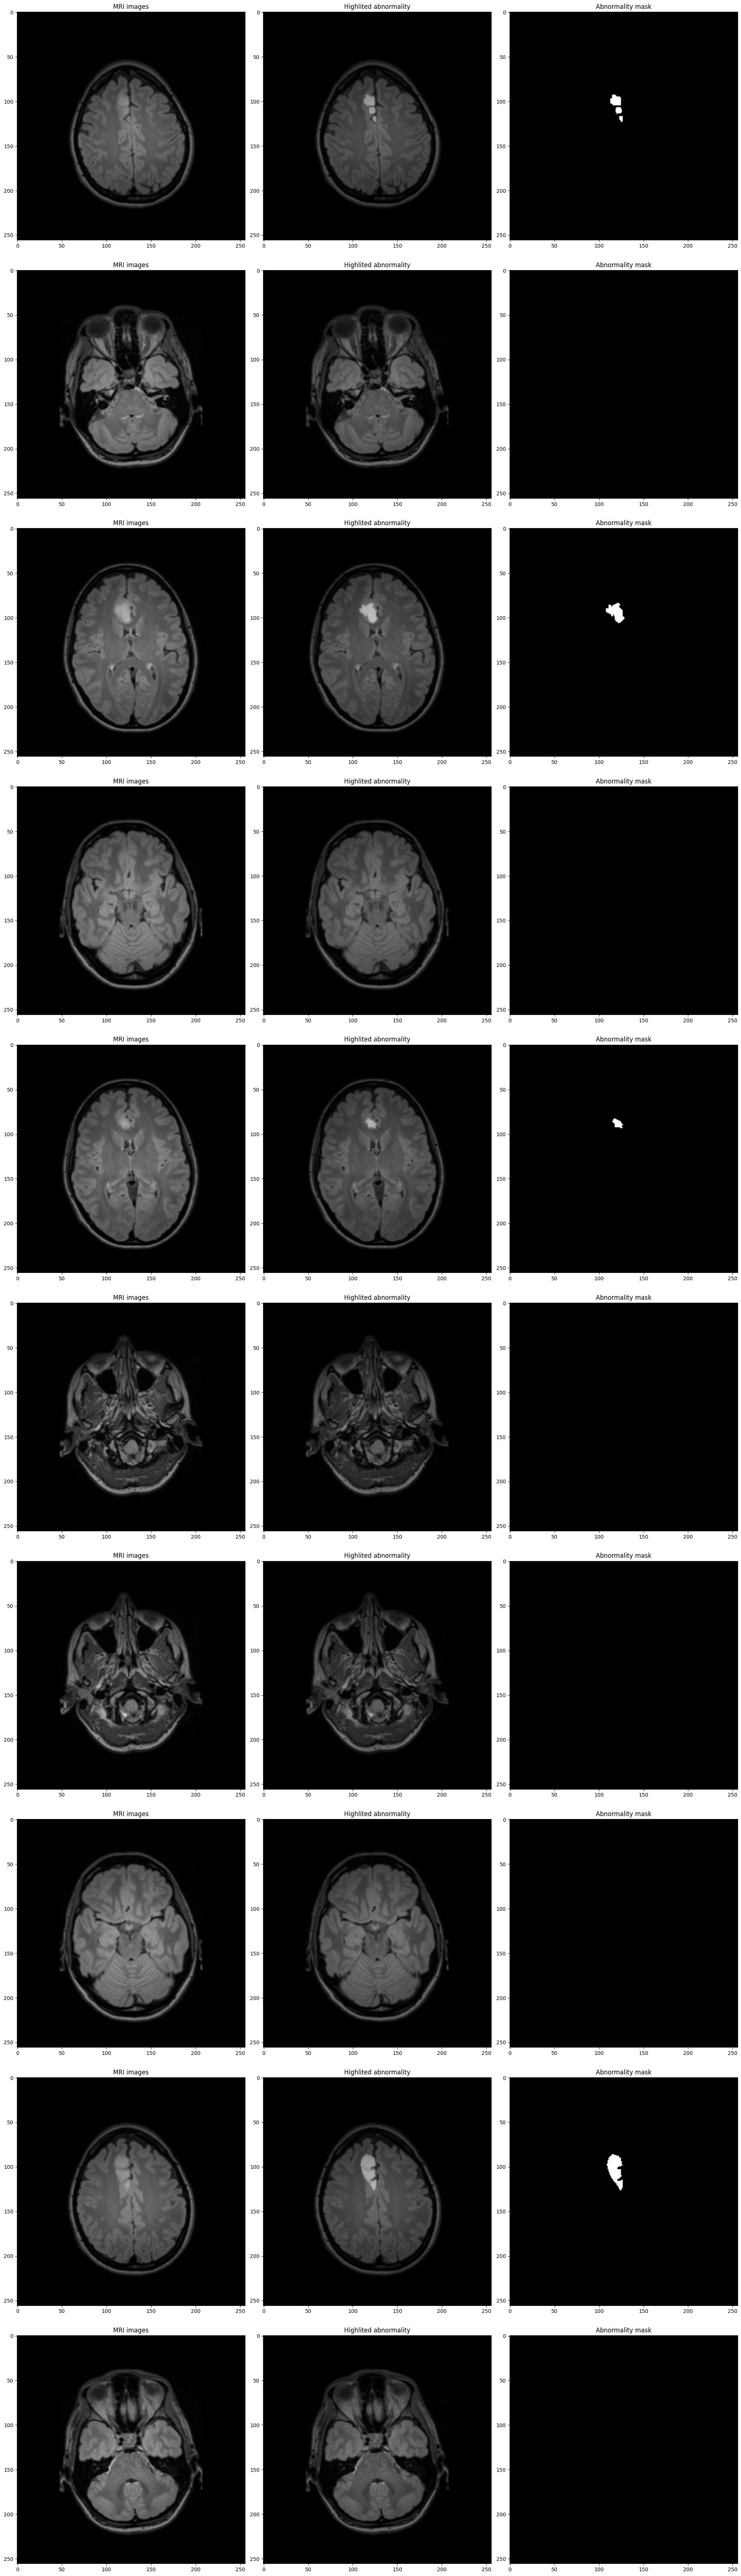

In [ ]:
def visualize(num_samples: int):
    fig, axes = plt.subplots(num_samples, 3, figsize=(20, 70), constrained_layout=True)
    start = 3919
    for sample in range(start, start+num_samples):
        img = cv2.imread(image_dataset[sample])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[(sample-start, 0)].set_title("MRI images")
        axes[(sample-start, 0)].imshow(img)
        axes[(sample-start, 1)].set_title("Highlited abnormality")
        axes[(sample-start, 1)].imshow(img)
        img = cv2.imread(mask_files[sample])
        axes[(sample-start, 1)].imshow(img, alpha=0.2)
        axes[(sample-start, 2)].set_title("Abnormality mask")
        axes[(sample-start, 2)].imshow(img)

visualize(10)

## 2. Preprocessing

Here we use glob to extract the datset.

In [7]:
image_filenames_train = []

mask_files = glob.glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

len(image_filenames_train)

3929

Here we split our dataset into train, validation and test set with the following ratios:

- Train: 0.8

- Validation: 0.1

- Test: 0.1

And also declare the batch size as 16 and the image size as 128 x 128.

In [ ]:
df = pd.DataFrame({'image': image_filenames_train, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)

img_height = 128
img_width = 128
batch_size = 16

Here we load our images make them suitable for our keras and tensorflow model.

Note that return our images in a tuple of image and its corresponding mask image.

and in the next cell we make them into batches.

In [ ]:
def load_image(image_path, mask=False):
    img = tifffile.imread(image_path.numpy().decode('utf-8'))

    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)

    img = tf.convert_to_tensor(img)
    img = tf.image.resize(img, [img_height, img_width])

    if not mask:
        img = tf.cast(img, tf.float32) / 255.0
        if img.shape[-1] == 1:
            img = tf.repeat(img, 3, axis=-1)
    else:
        img = tf.cast(img > 0, tf.float32)
        if img.shape[-1] != 1:
            img = tf.expand_dims(img, axis=-1)

    return img

def tf_load_image(image_path, mask_path):
    def _load_image(image_path, mask_path):
        image = load_image(image_path, mask=False)
        mask = load_image(mask_path, mask=True)
        return image, mask
    image, mask = tf.py_function(
        _load_image, [image_path, mask_path], [tf.float32, tf.float32]
    )
    image.set_shape([img_height, img_width, 3])
    mask.set_shape([img_height, img_width, 1])
    return image, mask

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (df_train['image'].values, df_train['mask'].values)
).shuffle(100).map(tf_load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (df_val['image'].values, df_val['mask'].values)
).map(tf_load_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (df_test['image'].values, df_test['mask'].values)
).map(tf_load_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
sample_image, sample_mask = next(iter(train_ds))
print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

Image shape: (16, 128, 128, 3)
Mask shape: (16, 128, 128, 1)


Here we visualize some of the images and its corresponding masks.

In [ ]:
train_images, train_masks = [], []
cnt = 0
for img_batch, mask_batch in train_ds:
    train_images.extend(img_batch.numpy())
    train_masks.extend(mask_batch.numpy())
    cnt += 1
    if cnt == 10:
      break

train_images = np.array(train_images)
train_masks = np.array(train_masks)

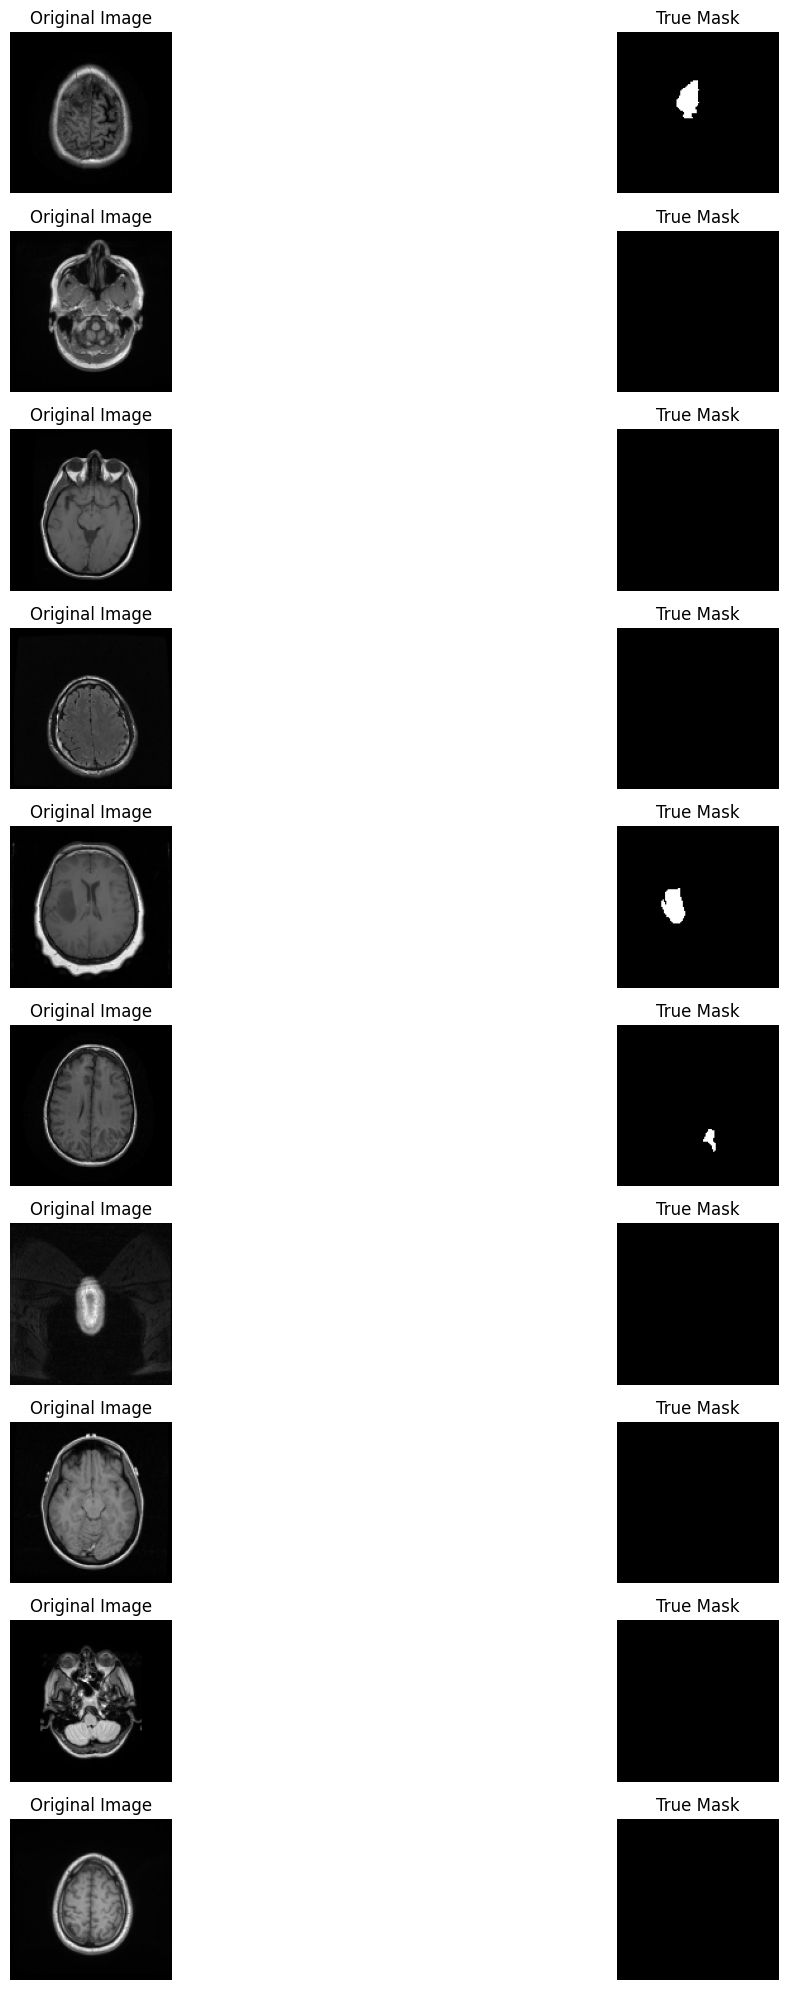

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(train_images[i][..., 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(train_masks[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 3. Implementation, Training, and Validation of the Model

The overall model has been explained in the report please refer to the report for more details.

But the overall idea is the same as what was in its original paper except I added batch normalization.

In [ ]:
def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = BatchNormalization()(conv1)
    bn1 = Activation("relu")(bn1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization()(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = BatchNormalization()(conv2)
    bn2 = Activation("relu")(bn2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization()(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = BatchNormalization()(conv3)
    bn3 = Activation("relu")(bn3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization()(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = BatchNormalization()(conv4)
    bn4 = Activation("relu")(bn4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization()(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = BatchNormalization()(conv5)
    bn5 = Activation("relu")(bn5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization()(conv5)
    bn5 = Activation("relu")(bn5)


    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = BatchNormalization()(conv6)
    bn6 = Activation("relu")(bn6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization()(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = BatchNormalization()(conv7)
    bn7 = Activation("relu")(bn7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization()(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = BatchNormalization()(conv8)
    bn8 = Activation("relu")(bn8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization()(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = BatchNormalization()(conv9)
    bn9 = Activation("relu")(bn9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization()(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Here is the formula that we used for our metrics and loss functions:

### $$Dice = (2*|X ∩ Y| + smooth) / (|X| + |Y| + smooth)$$

### $$DiceLoss = 1 - Dice$$

### $$Sensitivity = TP / (TP + FN)$$

### $$Specificity = TN / (TN + FP)$$

### $$FalseNegativeProportion = FN / (FN + TP) = 1 - Sensitivity$$

### $$IOU = TP / (TP + FP + FN)$$

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-5):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def false_negative_proportion(y_true, y_pred):
    false_negatives = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return false_negatives / (possible_positives + K.epsilon())

class BinaryIoU(Metric):
    def __init__(self, threshold=0.5, name='iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_pred = tf.cast(y_pred >= self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return self.intersection / (self.union + 1e-7)

    def reset_state(self):
        self.intersection.assign(0.0)
        self.union.assign(0.0)

In [ ]:
model = unet(input_size=(img_height, img_width, 3))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', BinaryIoU(threshold=0.5, name='iou'), dice_coefficient, sensitivity, specificity, false_negative_proportion]
)

Here we save our best model so that we can test it afterwards.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/unet_model_brain_mri.keras',
    monitor='val_dice_coefficient',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [8]:
print("Num GPU: ", len(tf.config.list_physical_devices('GPU')))

Num GPU:  1


In [ ]:
history = model.fit(train_ds, epochs=50, batch_size=16, validation_data = val_ds, callbacks=[checkpoint_callback])

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9308 - dice_coefficient: 0.0693 - false_negative_proportion: 0.6669 - io_u: 5.5906e-04 - loss: 0.2261 - sensitivity: 0.3317 - specificity: 0.9370
Epoch 1: val_dice_coefficient improved from -inf to 0.02058, saving model to /content/drive/MyDrive/unet_model_brain_mri.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 175s 586ms/step - accuracy: 0.9310 - dice_coefficient: 0.0696 - false_negative_proportion: 0.6669 - io_u: 5.5779e-04 - loss: 0.2256 - sensitivity: 0.3318 - specificity: 0.9373 - val_accuracy: 0.9882 - val_dice_coefficient: 0.0206 - val_false_negative_proportion: 0.9839 - val_io_u: 0.0000e+00 - val_loss: 0.0783 - val_sensitivity: 0.0161 - val_specificity: 1.0000
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9917 - dice_coefficient: 0.2241 - false_negative_proportion: 0.6028 - io_u: 0.0000e+00 - loss: 0.0393 - sensitivity: 0.3972 - specificity: 0.9979
Epoch 2: val_dice_coefficient improved from 0.02058 

Let's see the training and validation history over epochs.

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_fnp = history.history['false_negative_proportion']
val_fnp = history.history['val_false_negative_proportion']

train_dice = history.history['dice_coefficient']
val_dice = history.history['val_dice_coefficient']

train_sensitivity = history.history['sensitivity']
val_sensitivity = history.history['val_sensitivity']

train_specificity = history.history['specificity']
val_specificity = history.history['val_specificity']

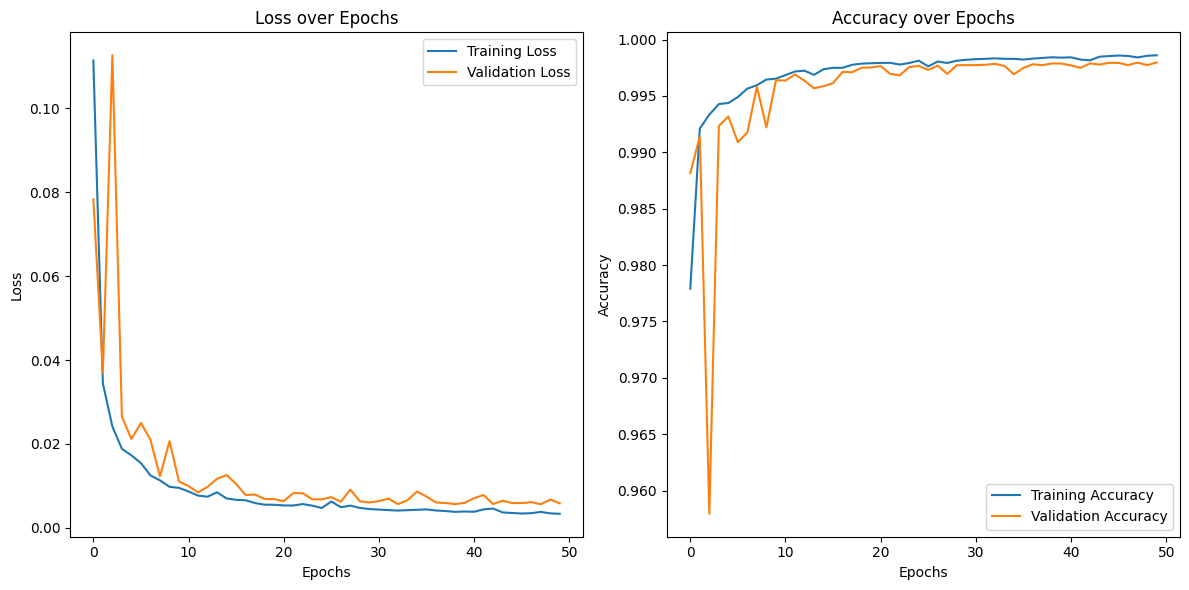

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

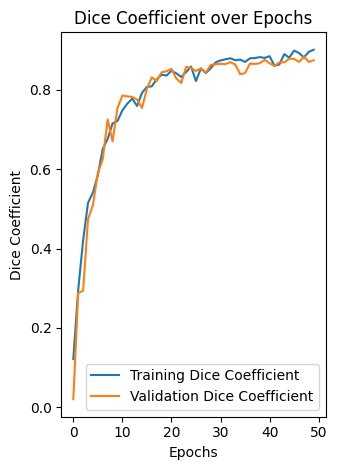

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_dice, label='Training Dice Coefficient')
plt.plot(val_dice, label='Validation Dice Coefficient')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


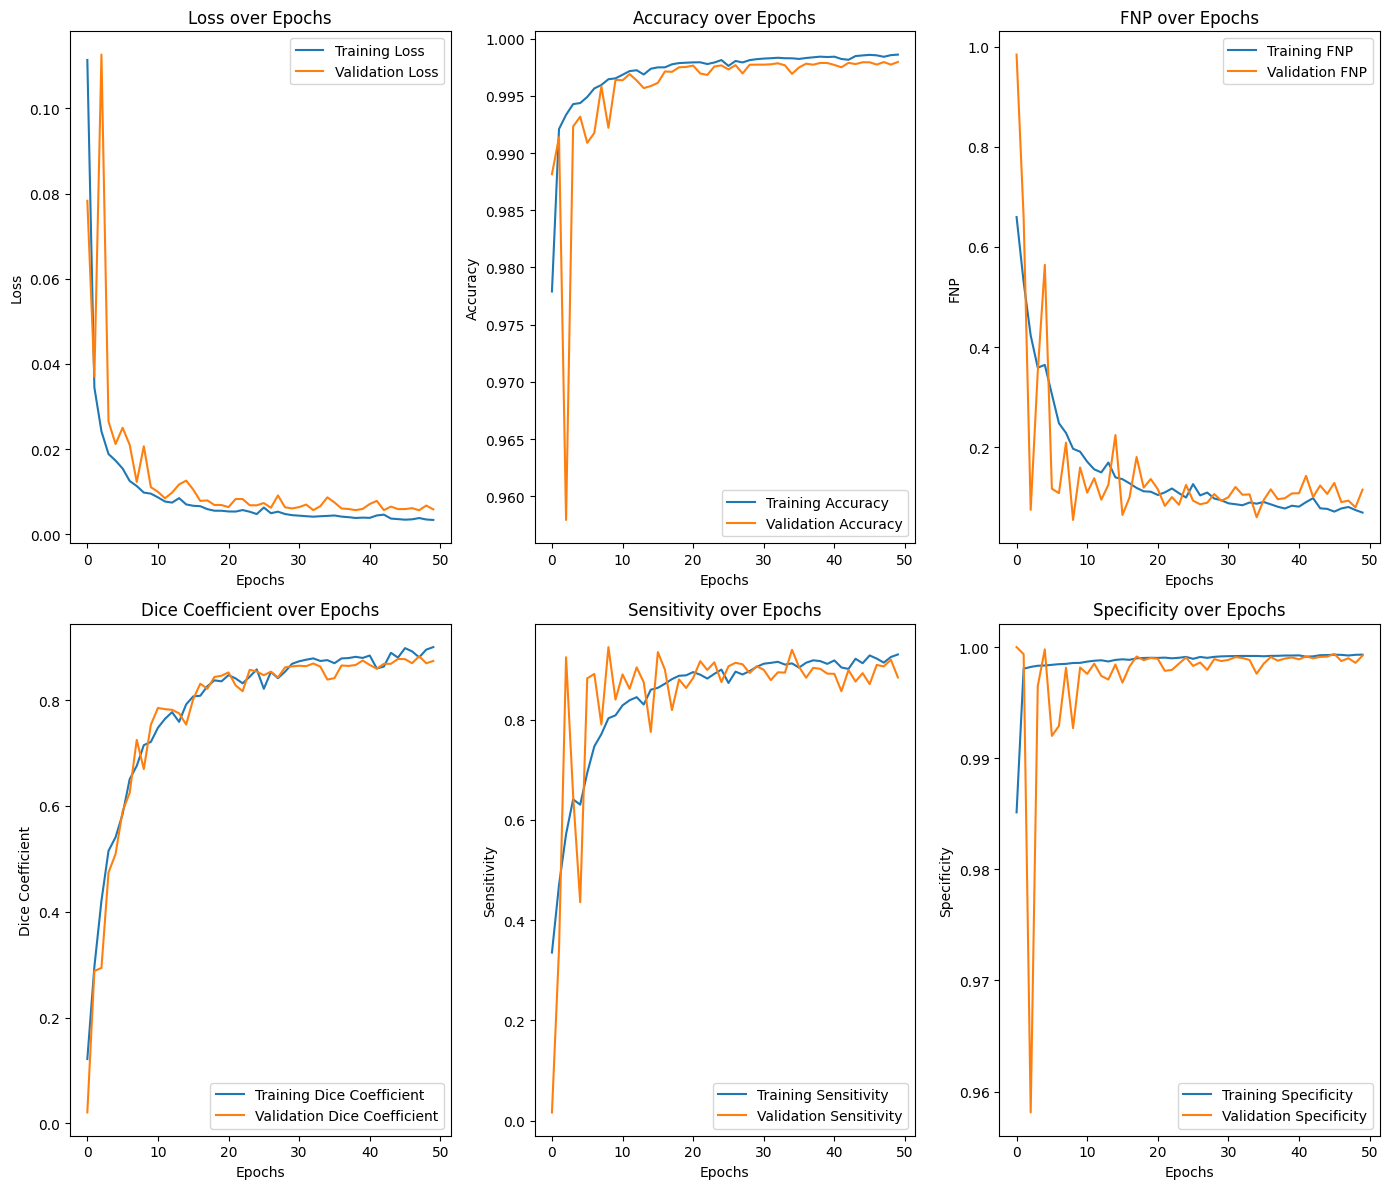

In [ ]:
plt.figure(figsize=(14, 12))

plt.subplot(2, 3, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_fnp, label='Training FNP')
plt.plot(val_fnp, label='Validation FNP')
plt.title('FNP over Epochs')
plt.xlabel('Epochs')
plt.ylabel('FNP')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_dice, label='Training Dice Coefficient')
plt.plot(val_dice, label='Validation Dice Coefficient')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_sensitivity, label='Training Sensitivity')
plt.plot(val_sensitivity, label='Validation Sensitivity')
plt.title('Sensitivity over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(train_specificity, label='Training Specificity')
plt.plot(val_specificity, label='Validation Specificity')
plt.title('Specificity over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Results and Analysis

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/unet_model_brain_mri.keras', custom_objects={'dice_coefficient': dice_coefficient, 'sensitivity': sensitivity, 'specificity': specificity, 'false_negative_proportion': false_negative_proportion})

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', BinaryIoU(threshold=0.5, name='iou'), dice_coefficient, sensitivity, specificity, false_negative_proportion]
)

In [ ]:
predictions = model.predict(test_ds)
binary_preds = (predictions > 0.5).astype(np.float32)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step


In [ ]:
test_images, test_masks = [], []
for img_batch, mask_batch in test_ds:
    test_images.extend(img_batch.numpy())
    test_masks.extend(mask_batch.numpy())

test_images = np.array(test_images)
test_masks = np.array(test_masks)

Here are some results:

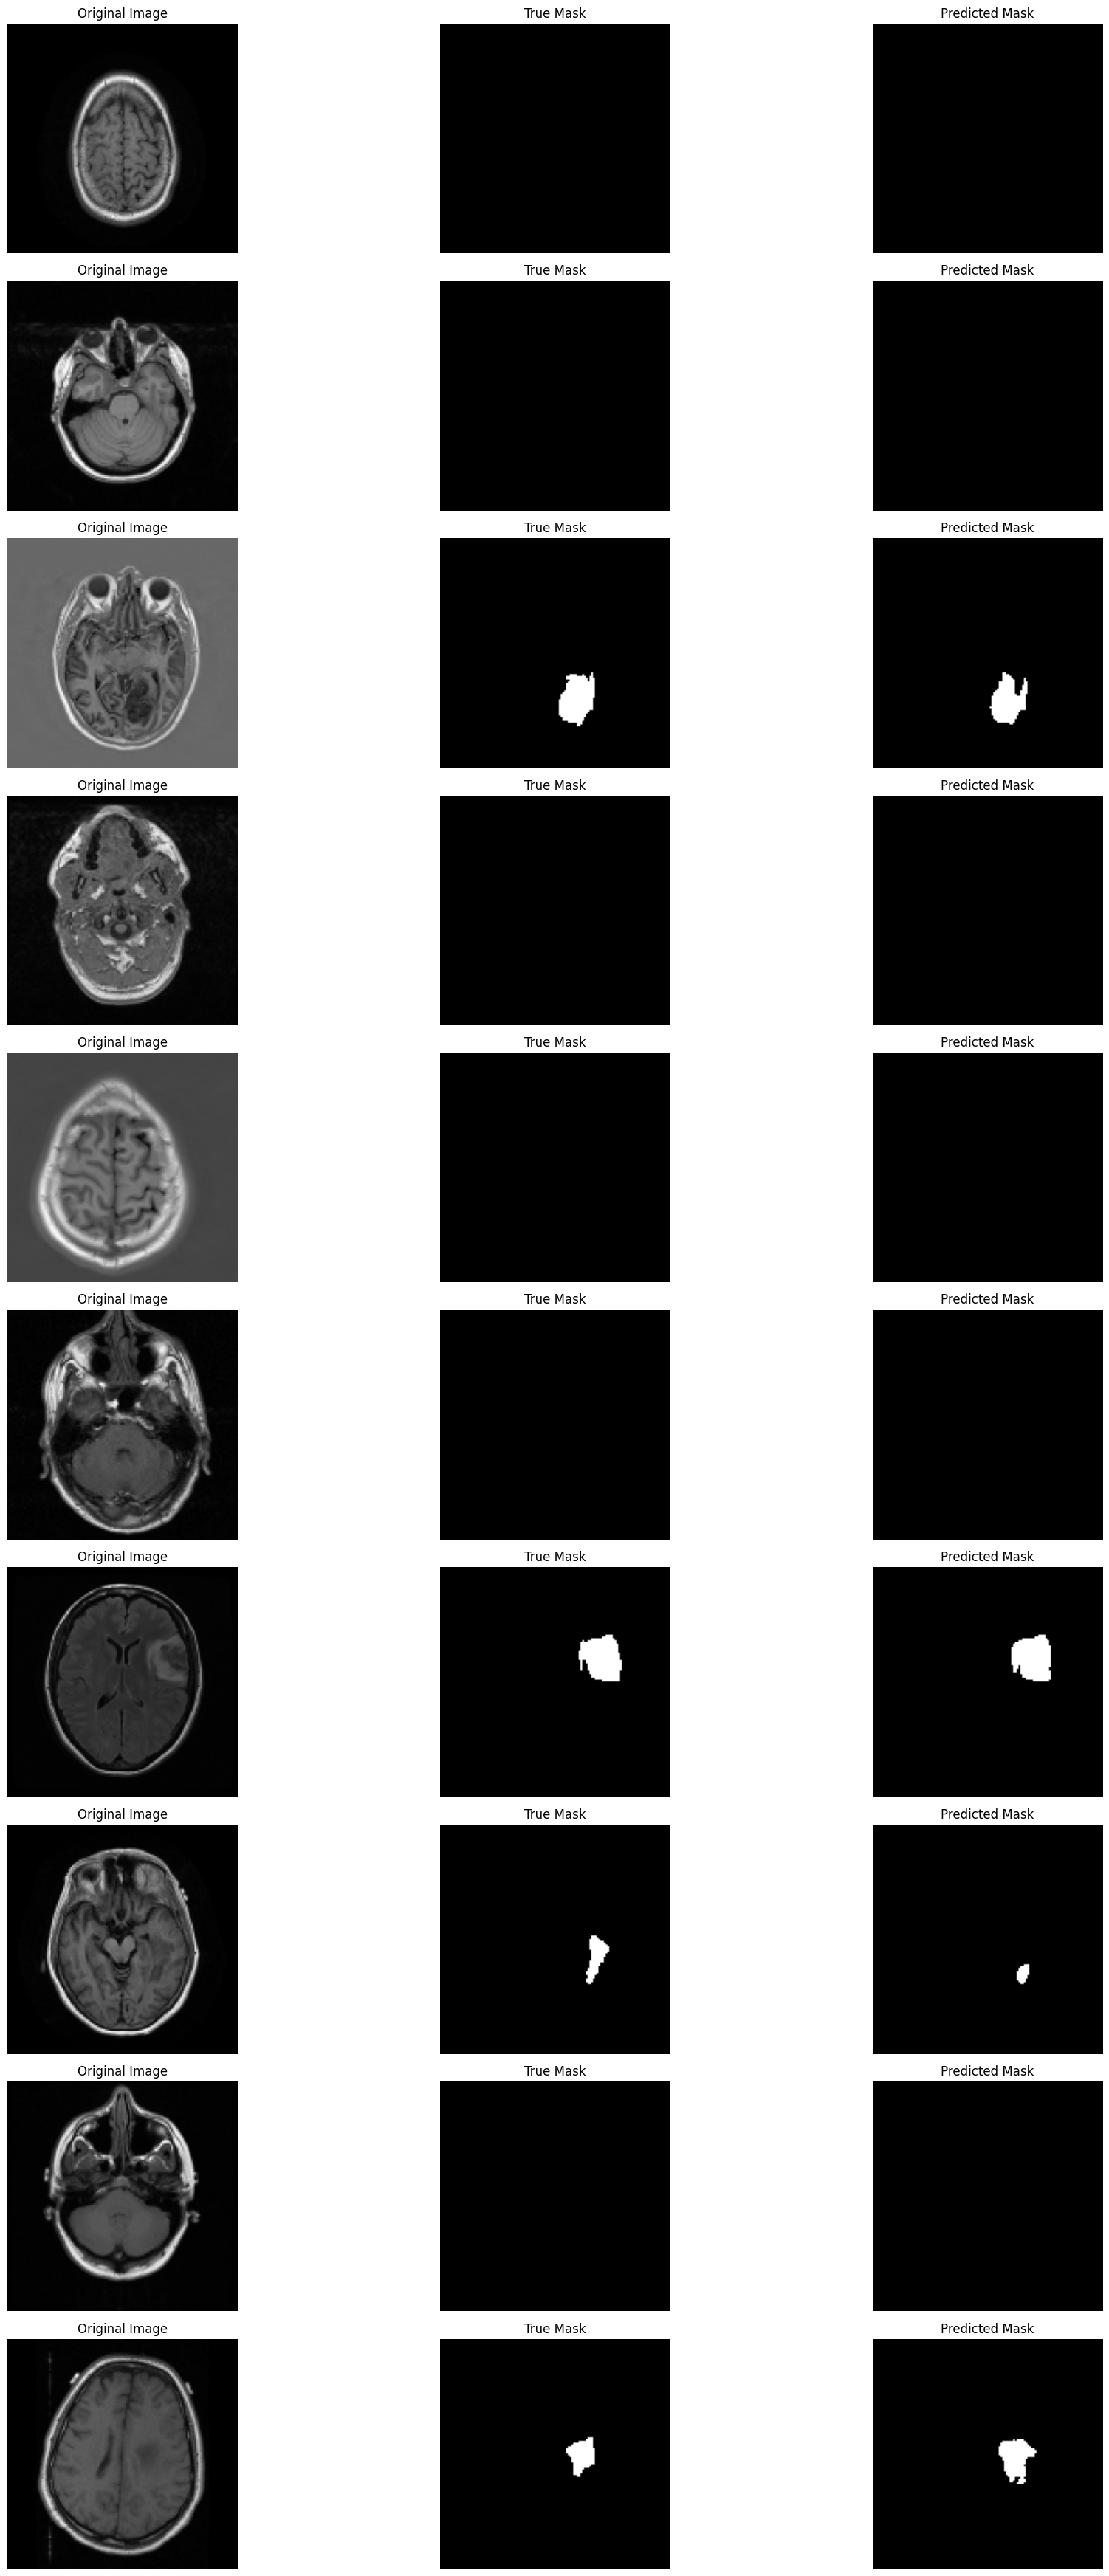

In [ ]:
plt.figure(figsize=(20, 35))
for i in range(10):
    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(test_images[i][..., 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(binary_preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test IOU: {results[2]}")
print(f"Test Dice Coefficient: {results[3]}")
print(f"Test Sensitivity: {results[4]}")
print(f"Test Specificity: {results[5]}")
print(f"Test False Negative Proportion: {results[6]}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9978 - dice_coefficient: 0.8767 - false_negative_proportion: 0.1034 - iou: 0.8298 - loss: 0.0062 - sensitivity: 0.8966 - specificity: 0.9990
Test Loss: 0.005496591329574585
Test Accuracy: 0.9980392456054688
Test IOU: 0.8399994969367981
Test Dice Coefficient: 0.8792596459388733
Test Sensitivity: 0.9041658043861389
Test Specificity: 0.9990432262420654
Test False Negative Proportion: 0.09583411365747452


In [ ]:
results_val = model.evaluate(val_ds)
print(f"Val Loss: {results_val[0]}")
print(f"Val Accuracy: {results_val[1]}")
print(f"Val IOU: {results_val[2]}")
print(f"Val Dice Coefficient: {results_val[3]}")
print(f"Val Sensitivity: {results_val[4]}")
print(f"Val Specificity: {results_val[5]}")
print(f"Val False Negative Proportion: {results_val[6]}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.9981 - dice_coefficient: 0.8943 - false_negative_proportion: 0.0871 - iou: 0.8545 - loss: 0.0052 - sensitivity: 0.9129 - specificity: 0.9991
Val Loss: 0.005626706872135401
Val Accuracy: 0.9979510307312012
Val IOU: 0.842785120010376
Val Dice Coefficient: 0.8830697536468506
Val Sensitivity: 0.9062381982803345
Val Specificity: 0.998995304107666
Val False Negative Proportion: 0.09376175701618195


In [ ]:
results_train = model.evaluate(train_ds)
print(f"Train Loss: {results_train[0]}")
print(f"Train Accuracy: {results_train[1]}")
print(f"Train IOU: {results_train[2]}")
print(f"Train Dice Coefficient: {results_train[3]}")
print(f"Train Sensitivity: {results_train[4]}")
print(f"Train Specificity: {results_train[5]}")
print(f"Train False Negative Proportion: {results_train[6]}")

197/197 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.9986 - dice_coefficient: 0.8968 - false_negative_proportion: 0.0648 - iou: 0.8753 - loss: 0.0032 - sensitivity: 0.9352 - specificity: 0.9992
Train Loss: 0.003348730504512787
Train Accuracy: 0.9985792636871338
Train IOU: 0.8782213926315308
Train Dice Coefficient: 0.8986504077911377
Train Sensitivity: 0.9354705214500427
Train Specificity: 0.9992177486419678
Train False Negative Proportion: 0.06452956050634384


In [ ]:
data = {
    'Metric': ['Loss', 'Accuracy', 'Dice Coefficient', 'Sensitivity', 'Specificity', 'False Negative Proportion'],
    'Train': [results_train[0], results_train[1], results_train[3], results_train[4], results_train[5], results_train[6]],
    'Validation': [results_val[0], results_val[1], results_val[3], results_val[4], results_val[5], results_val[6]],
    'Test': [results[0], results[1], results[3], results[4], results[5], results[6]]
}

df_results = pd.DataFrame(data)

df_results

Metric     Train  Validation      Test
0                       Loss  0.003349    0.005627  0.005497
1                   Accuracy  0.998579    0.997951  0.998039
2           Dice Coefficient  0.898650    0.883070  0.879260
3                Sensitivity  0.935471    0.906238  0.904166
4                Specificity  0.999218    0.998995  0.999043
5  False Negative Proportion  0.064530    0.093762  0.095834

Here is the confusion matrix, Please note that the numbers are essentially the pixel numbers hence they are this large!

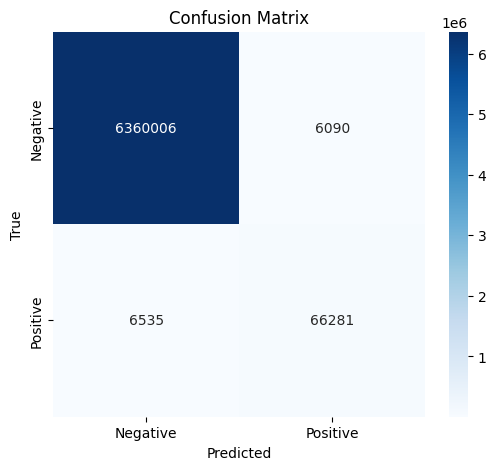

In [ ]:
y_true = test_masks.flatten()
y_pred = binary_preds.flatten()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

# Bonus

# Testing different variations of UNet model.

### TransUNet

The following cells prepare the data for our torch model.

In [9]:
image_filenames_train = []

mask_files = glob.glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

len(image_filenames_train)

3929

In [ ]:
df = pd.DataFrame({'image': image_filenames_train, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)

img_height = 224
img_width = 224
batch_size = 16

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

mask_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width), interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0).float())
])

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, dataframe, transform_img=None, transform_mask=None):
        self.dataframe = dataframe
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        mask_path = self.dataframe.iloc[idx]['mask']

        image = tifffile.imread(img_path)
        mask = tifffile.imread(mask_path)

        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=-1)

        image = Image.fromarray(image.squeeze())
        mask = Image.fromarray(mask.squeeze())

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

train_dataset = SegmentationDataset(df_train, transform_img=image_transforms, transform_mask=mask_transforms)
val_dataset = SegmentationDataset(df_val, transform_img=image_transforms, transform_mask=mask_transforms)
test_dataset = SegmentationDataset(df_test, transform_img=image_transforms, transform_mask=mask_transforms)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

We're on gpu!

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

This is pretty vanilla TransUNet, the idea is to use ViT as a feature extractor in the encoder layer and then use somewhat the same decoder as in the original UNet.

Note that it's generally a better idea to use both UNet encoder and ViT as a feature extractor. (We also don't pass the features that often which is advised to do in UNet).

The reason why I didn't do the above, is that lack of Computational resources. Which was a challenge for me to train this model.

Note that I wanted to Fine-Tune the ViT model on this dataset hence the time consuming training.

In [ ]:
class TransUNet(nn.Module):
    def __init__(self, pretrained_model="google/vit-base-patch16-224", out_channels=1):
        super(TransUNet, self).__init__()

        self.encoder = AutoModel.from_pretrained(pretrained_model)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(pixel_values=x).last_hidden_state
        x = x[:, 1:, :]
        x = x.permute(0, 2, 1)
        x = x.view(x.size(0), 768, 14, 14)
        x = self.decoder(x)

        return x

In [ ]:
model = TransUNet()
model = model.to(device)

print(model)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TransUNet(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

Here are the same metrics just implemented for pytorch!

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_true_f = y_true.view(-1)
        y_pred_f = y_pred.view(-1)
        intersection = (y_true_f * y_pred_f).sum()
        dice = (2. * intersection + self.smooth) / (y_true_f.sum() + y_pred_f.sum() + self.smooth)
        return 1 - dice

class BCEPlusDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, y_pred, y_true):
        return self.bce(y_pred, y_true) + self.dice(y_pred, y_true)

def compute_metrics(y_pred_logits, y_true, threshold=0.5):
    y_pred = torch.sigmoid(y_pred_logits)
    y_pred_bin = (y_pred >= threshold).float()
    y_true = y_true.float()

    tp = (y_pred_bin * y_true).sum()
    tn = ((1 - y_pred_bin) * (1 - y_true)).sum()
    fp = (y_pred_bin * (1 - y_true)).sum()
    fn = ((1 - y_pred_bin) * y_true).sum()

    sensitivity = tp / (tp + fn + 1e-7)
    specificity = tn / (tn + fp + 1e-7)
    fnp = fn / (tp + fn + 1e-7)
    iou = tp / (tp + fp + fn + 1e-7)

    return sensitivity, specificity, fnp, iou

We make sure that every layer is trainable.

In [ ]:
criterion = DiceLoss()
optimizer = optim.AdamW(model.decoder.parameters(), lr=1e-4)

for param in model.encoder.parameters():
    param.requires_grad = True

for param in model.decoder.parameters():
    param.requires_grad = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/best_transunet_dice.pth"

In [ ]:
best_loss = float('inf')

for epoch in range(50):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_masks).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    if val_loss < best_loss:
        print(f"Validation loss improved from {best_loss:.4f} to {val_loss:.4f}")
        best_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, path)

    print(f"Epoch {epoch+1}/{50}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print("--------------------------------------------------")

100%|██████████| 197/197 [02:02<00:00,  1.60it/s]


Validation loss improved from inf to 0.9198
Epoch 1/50
Train Loss: 0.9331 | Val Loss: 0.9198
--------------------------------------------------


100%|██████████| 197/197 [02:02<00:00,  1.60it/s]


Validation loss improved from 0.9198 to 0.8683
Epoch 2/50
Train Loss: 0.8842 | Val Loss: 0.8683
--------------------------------------------------


100%|██████████| 197/197 [02:02<00:00,  1.60it/s]


Validation loss improved from 0.8683 to 0.7786
Epoch 3/50
Train Loss: 0.8109 | Val Loss: 0.7786
--------------------------------------------------


100%|██████████| 197/197 [02:02<00:00,  1.60it/s]


Validation loss improved from 0.7786 to 0.6437
Epoch 4/50
Train Loss: 0.6861 | Val Loss: 0.6437
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.6437 to 0.5148
Epoch 5/50
Train Loss: 0.5418 | Val Loss: 0.5148
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.5148 to 0.4375
Epoch 6/50
Train Loss: 0.4365 | Val Loss: 0.4375
--------------------------------------------------


100%|██████████| 197/197 [02:02<00:00,  1.60it/s]


Validation loss improved from 0.4375 to 0.3817
Epoch 7/50
Train Loss: 0.3493 | Val Loss: 0.3817
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.3817 to 0.3391
Epoch 8/50
Train Loss: 0.2990 | Val Loss: 0.3391
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.3391 to 0.3212
Epoch 9/50
Train Loss: 0.2660 | Val Loss: 0.3212
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.3212 to 0.3118
Epoch 10/50
Train Loss: 0.2548 | Val Loss: 0.3118
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.3118 to 0.2927
Epoch 11/50
Train Loss: 0.2327 | Val Loss: 0.2927
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2927 to 0.2817
Epoch 12/50
Train Loss: 0.2170 | Val Loss: 0.2817
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2817 to 0.2789
Epoch 13/50
Train Loss: 0.2012 | Val Loss: 0.2789
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2789 to 0.2746
Epoch 14/50
Train Loss: 0.2034 | Val Loss: 0.2746
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 15/50
Train Loss: 0.2045 | Val Loss: 0.2808
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2746 to 0.2611
Epoch 16/50
Train Loss: 0.1722 | Val Loss: 0.2611
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 17/50
Train Loss: 0.1667 | Val Loss: 0.2685
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2611 to 0.2607
Epoch 18/50
Train Loss: 0.1664 | Val Loss: 0.2607
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2607 to 0.2598
Epoch 19/50
Train Loss: 0.1561 | Val Loss: 0.2598
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2598 to 0.2509
Epoch 20/50
Train Loss: 0.1622 | Val Loss: 0.2509
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 21/50
Train Loss: 0.1476 | Val Loss: 0.2584
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 22/50
Train Loss: 0.1429 | Val Loss: 0.2581
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 23/50
Train Loss: 0.1446 | Val Loss: 0.2511
--------------------------------------------------


100%|██████████| 197/197 [02:02<00:00,  1.60it/s]


Epoch 24/50
Train Loss: 0.1347 | Val Loss: 0.2615
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 25/50
Train Loss: 0.1509 | Val Loss: 0.2905
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 26/50
Train Loss: 0.1386 | Val Loss: 0.2584
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 27/50
Train Loss: 0.1312 | Val Loss: 0.2619
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 28/50
Train Loss: 0.1289 | Val Loss: 0.2562
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2509 to 0.2436
Epoch 29/50
Train Loss: 0.1256 | Val Loss: 0.2436
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 30/50
Train Loss: 0.1197 | Val Loss: 0.2691
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 31/50
Train Loss: 0.1152 | Val Loss: 0.2572
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2436 to 0.2427
Epoch 32/50
Train Loss: 0.1148 | Val Loss: 0.2427
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 33/50
Train Loss: 0.1085 | Val Loss: 0.2512
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 34/50
Train Loss: 0.1196 | Val Loss: 0.2530
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 35/50
Train Loss: 0.1020 | Val Loss: 0.2457
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 36/50
Train Loss: 0.1050 | Val Loss: 0.2569
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 37/50
Train Loss: 0.1016 | Val Loss: 0.2483
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2427 to 0.2414
Epoch 38/50
Train Loss: 0.0992 | Val Loss: 0.2414
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 39/50
Train Loss: 0.1115 | Val Loss: 0.2453
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 40/50
Train Loss: 0.0947 | Val Loss: 0.2469
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 41/50
Train Loss: 0.0946 | Val Loss: 0.2523
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 42/50
Train Loss: 0.0948 | Val Loss: 0.2439
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 43/50
Train Loss: 0.0894 | Val Loss: 0.2436
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 44/50
Train Loss: 0.0954 | Val Loss: 0.2491
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 45/50
Train Loss: 0.1032 | Val Loss: 0.2418
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2414 to 0.2391
Epoch 46/50
Train Loss: 0.0891 | Val Loss: 0.2391
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 47/50
Train Loss: 0.0861 | Val Loss: 0.2395
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 48/50
Train Loss: 0.0930 | Val Loss: 0.2428
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Validation loss improved from 0.2391 to 0.2347
Epoch 49/50
Train Loss: 0.0911 | Val Loss: 0.2347
--------------------------------------------------


100%|██████████| 197/197 [02:03<00:00,  1.60it/s]


Epoch 50/50
Train Loss: 0.0940 | Val Loss: 0.2502
--------------------------------------------------


In [ ]:
model = TransUNet().to(device)

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-3edd7f80ba13>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

<All keys matched successfully>

Here are the results of our Vanilla TransUNet model.

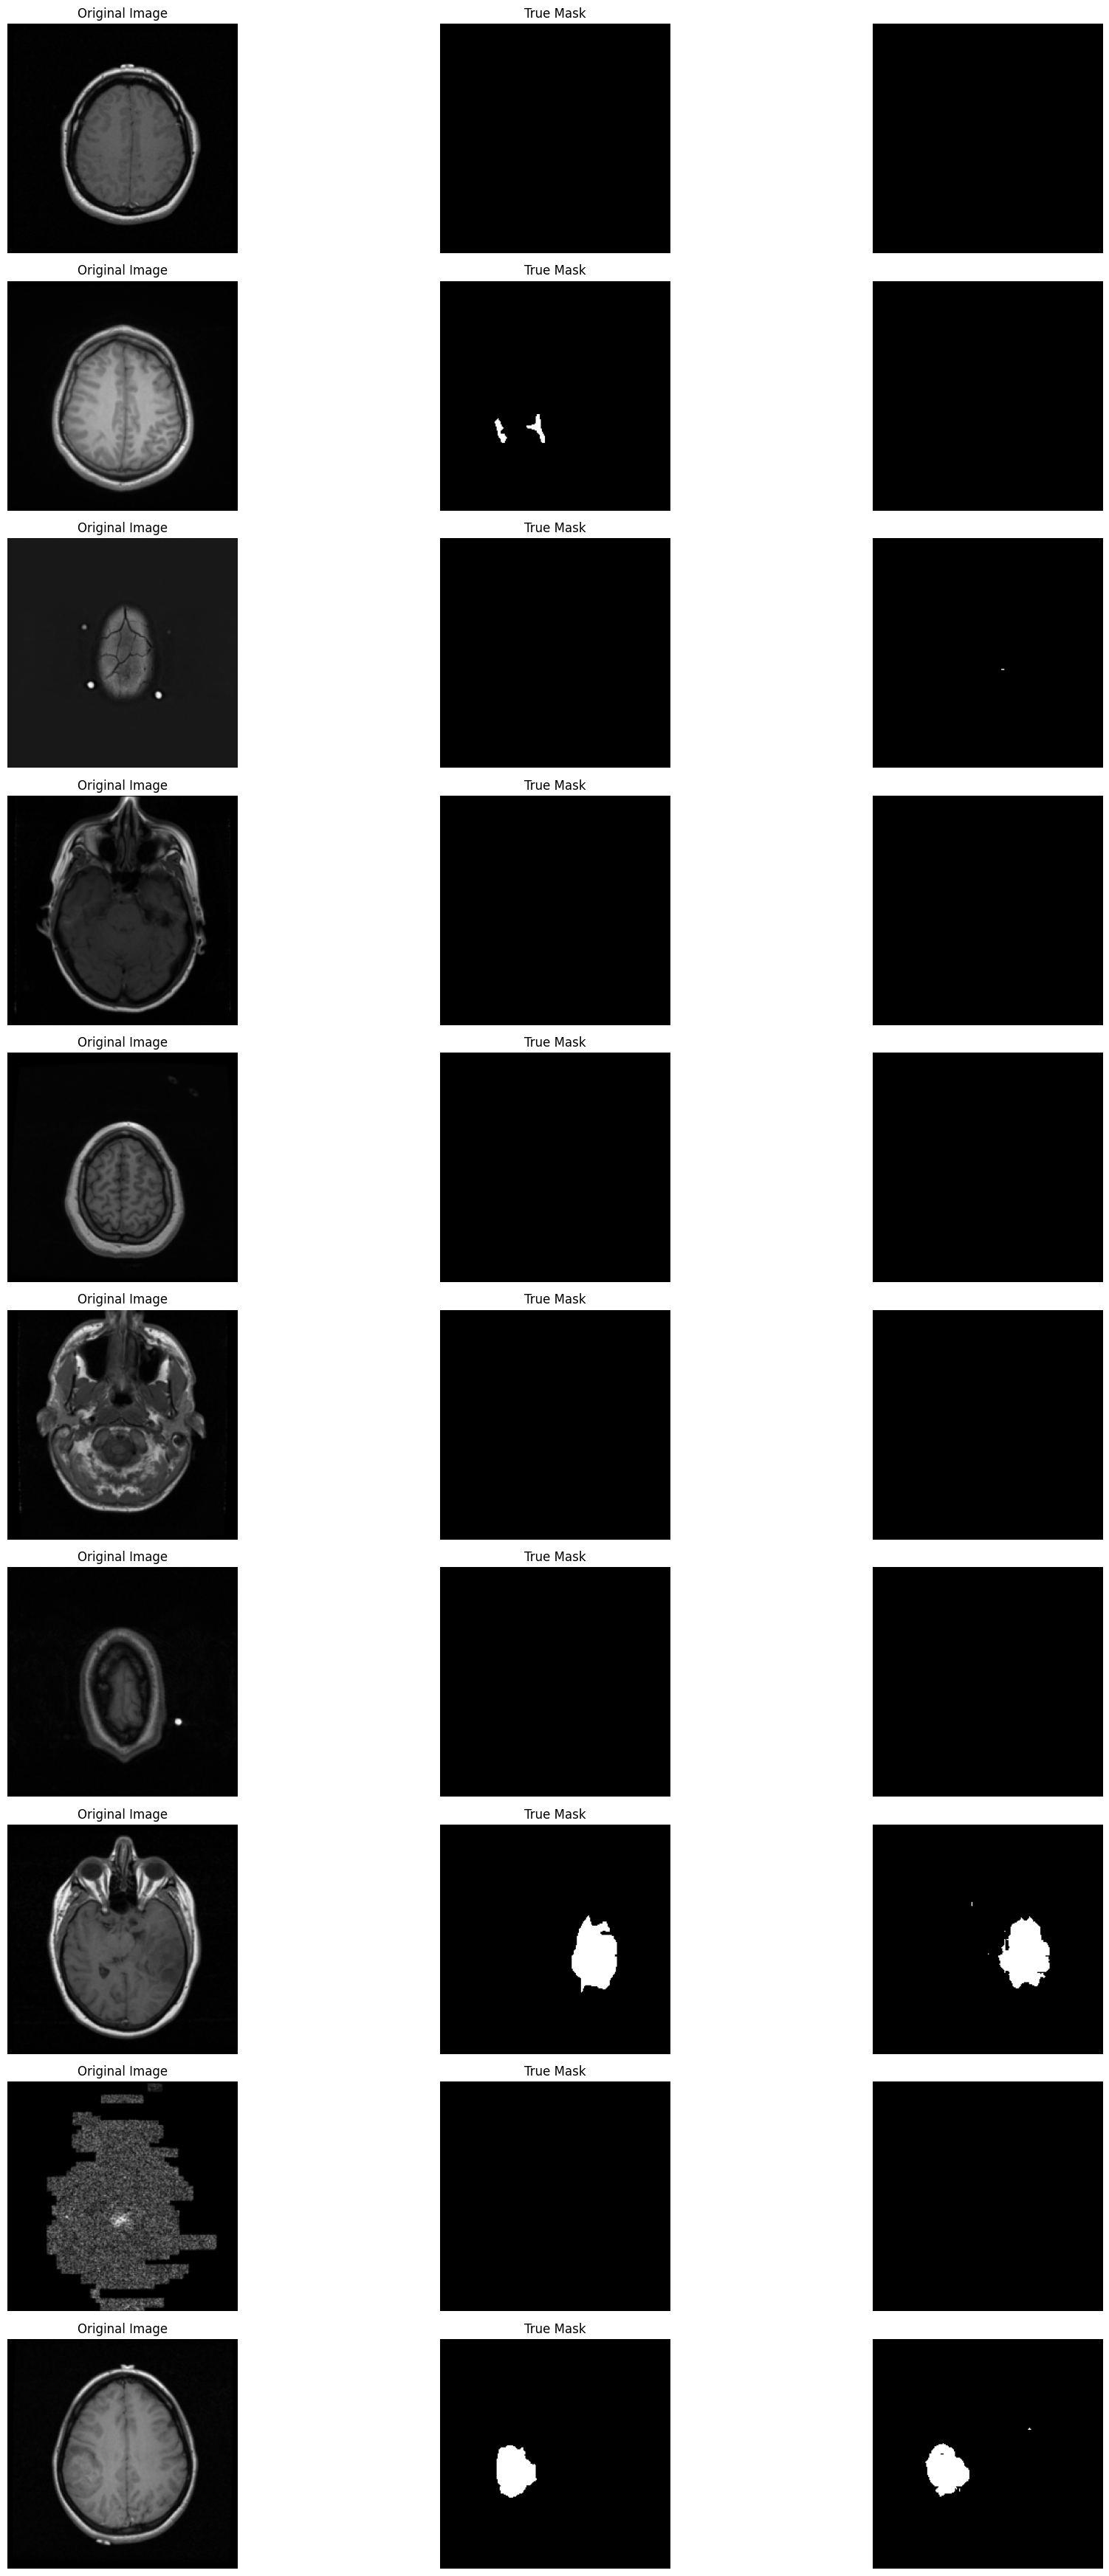

In [ ]:
model.eval()
test_images = []
test_masks = []
preds = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = model(images)

        test_images.extend(images.cpu().numpy())
        test_masks.extend(masks.cpu().numpy())
        preds.extend(torch.sigmoid(outputs).cpu().numpy())

test_images = np.array(test_images)
test_masks = np.array(test_masks)
preds = np.array(preds)
binary_preds = (preds > 0.5).astype(np.float32)

plt.figure(figsize=(20, 35))
for i in range(10):
    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(test_images[i].transpose(1, 2, 0)[..., 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(binary_preds[i].squeeze(), cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def calculate_metrics(preds, targets):
    tp = np.sum((preds == 1) & (targets == 1))
    tn = np.sum((preds == 0) & (targets == 0))
    fp = np.sum((preds == 1) & (targets == 0))
    fn = np.sum((preds == 0) & (targets == 1))

    sensitivity = tp / (tp + fn + 1e-7)
    specificity = tn / (tn + fp + 1e-7)
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-7)
    iou = tp / (tp + fp + fn + 1e-7)

    return dice, iou, sensitivity, specificity


dice, iou, sens, spec = calculate_metrics(binary_preds, test_masks)
res_test = [dice, iou, sens]
print(f"Test Metrics: Dice: {dice:.4f}, IoU: {iou:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}")

Test Metrics: Dice: 0.7715, IoU: 0.6280, Sensitivity: 0.7150, Specificity: 0.9988


In [ ]:
model.eval()
preds = []
val_masks = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model(images)

        val_masks.extend(masks.cpu().numpy())
        preds.extend(torch.sigmoid(outputs).cpu().numpy())

val_masks = np.array(val_masks)
preds = np.array(preds)
binary_preds = (preds > 0.5).astype(np.float32)
dice, iou, sens, spec = calculate_metrics(binary_preds, val_masks)
res_val = [dice, iou, sens]
print(f"Validation Metrics: Dice: {dice:.4f}, IoU: {iou:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}")

Validation Metrics: Dice: 0.7673, IoU: 0.6224, Sensitivity: 0.7245, Specificity: 0.9984


In [ ]:
model.eval()
preds = []
train_masks = []

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        outputs = model(images)

        train_masks.extend(masks.cpu().numpy())
        preds.extend(torch.sigmoid(outputs).cpu().numpy())

train_masks = np.array(train_masks)
preds = np.array(preds)
binary_preds = (preds > 0.5).astype(np.float32)
dice, iou, sens, spec = calculate_metrics(binary_preds, train_masks)
res_train = [dice, iou, sens]
print(f"Train Metrics: Dice: {dice:.4f}, IoU: {iou:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}")

Train Metrics: Dice: 0.9218, IoU: 0.8550, Sensitivity: 0.9165, Specificity: 0.9992


As you can see below, the results are not as good as the other model for the reasons I explained earlier!

In [ ]:
data = {
    'Metric': ['Dice Coefficient', 'IoU', 'Sensitivity'],
    'Train': [res_train[0], res_train[1], res_train[2]],
    'Validation': [res_val[0], res_val[1], res_val[2]],
    'Test': [res_test[0], res_test[1], res_test[2]]
}


df_results = pd.DataFrame(data)

df_results

Metric     Train  Validation      Test
0  Dice Coefficient  0.921826    0.767283  0.771514
1               IoU  0.854989    0.622433  0.628020
2       Sensitivity  0.916524    0.724477  0.714994

## UNet++

In [10]:
image_filenames_train = []

mask_files = glob.glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

len(image_filenames_train)

3929

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-5):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def false_negative_proportion(y_true, y_pred):
    false_negatives = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return false_negatives / (possible_positives + K.epsilon())


class BinaryIoU(Metric):
    def __init__(self, threshold=0.5, name='iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_pred = tf.cast(y_pred >= self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return self.intersection / (self.union + 1e-7)

    def reset_state(self):
        self.intersection.assign(0.0)
        self.union.assign(0.0)

In [ ]:
@tf.keras.utils.register_keras_serializable()
class BinaryIoU(Metric):
    def __init__(self, threshold=0.5, name='iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_pred = tf.cast(y_pred >= self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return self.intersection / (self.union + 1e-7)

    def reset_state(self):
        self.intersection.assign(0.0)
        self.union.assign(0.0)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
df = pd.DataFrame({'image': image_filenames_train, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)

img_height = 128
img_width = 128
batch_size = 16

In [ ]:
def load_image(image_path, mask=False):
    img = tifffile.imread(image_path.numpy().decode('utf-8'))

    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)

    img = tf.convert_to_tensor(img)
    img = tf.image.resize(img, [img_height, img_width])

    if not mask:
        img = tf.cast(img, tf.float32) / 255.0
        if img.shape[-1] == 1:
            img = tf.repeat(img, 3, axis=-1)
    else:
        img = tf.cast(img > 0, tf.float32)
        if img.shape[-1] != 1:
            img = tf.expand_dims(img, axis=-1)

    return img

def tf_load_image(image_path, mask_path):
    def _load_image(image_path, mask_path):
        image = load_image(image_path, mask=False)
        mask = load_image(mask_path, mask=True)
        return image, mask
    image, mask = tf.py_function(
        _load_image, [image_path, mask_path], [tf.float32, tf.float32]
    )
    image.set_shape([img_height, img_width, 3])
    mask.set_shape([img_height, img_width, 1])
    return image, mask

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (df_train['image'].values, df_train['mask'].values)
).shuffle(100).map(tf_load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (df_val['image'].values, df_val['mask'].values)
).map(tf_load_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (df_test['image'].values, df_test['mask'].values)
).map(tf_load_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
def conv_block(x, filters, kernel_size=(3,3), padding="same"):
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

The idea of UNet++ is explained in the report!

In [ ]:
def unet_plus_plus(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    x00 = conv_block(inputs, 64)
    p0 = MaxPooling2D((2,2))(x00)
    x10 = conv_block(p0, 128)
    p1 = MaxPooling2D((2,2))(x10)
    x20 = conv_block(p1, 256)
    p2 = MaxPooling2D((2,2))(x20)
    x30 = conv_block(p2, 512)
    p3 = MaxPooling2D((2,2))(x30)

    x40 = conv_block(p3, 1024)


    x31 = Conv2DTranspose(512, (2,2), strides=(2,2), padding="same")(x40)
    x31 = concatenate([x31, x30])
    x31 = conv_block(x31, 512)

    x22 = Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(x31)
    x22 = concatenate([x22, x20])
    x22 = conv_block(x22, 256)

    x32 = Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(x31)
    x32 = concatenate([
        x32,
        Conv2DTranspose(512, (2,2), strides=(2,2), padding="same")(x30),
        x22
    ])
    x32 = conv_block(x32, 512)

    x13 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(x22)
    x13 = concatenate([x13, x10])
    x13 = conv_block(x13, 128)

    x23 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(x32)
    x23 = concatenate([
        x23,
        Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(x20),
        x13
    ])
    x23 = conv_block(x23, 256)

    x04 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(x13)
    x04 = concatenate([x04, x00])
    x04 = conv_block(x04, 64)

    x14 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(x23)
    x14 = concatenate([
        x14,
        Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(x10),
        x04
    ])
    x14 = conv_block(x14, 128)

    outputs = Conv2D(1, (1,1), activation="sigmoid")(x14)
    return Model(inputs=inputs, outputs=outputs)

model = unet_plus_plus()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 42,583,617 (162.44 MB)

 Trainable params: 42,568,257 (162.39 MB)

 Non-trainable params: 15,360 (60.00 KB)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/unet++_model_brain_mri.keras',
    monitor='val_dice_coefficient',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', BinaryIoU(threshold=0.5, name='iou'), dice_coefficient, sensitivity, specificity, false_negative_proportion]
)

In [ ]:
history = model.fit(train_ds, epochs=50, batch_size=16, validation_data = val_ds, callbacks=[checkpoint_callback])

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.9717 - dice_coefficient: 0.1981 - false_negative_proportion: 0.6421 - iou: 0.1734 - loss: 0.1082 - sensitivity: 0.3579 - specificity: 0.9792
Epoch 1: val_dice_coefficient improved from -inf to 0.02885, saving model to /content/drive/MyDrive/unet++_model_brain_mri.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.9717 - dice_coefficient: 0.1985 - false_negative_proportion: 0.6420 - iou: 0.1737 - loss: 0.1079 - sensitivity: 0.3580 - specificity: 0.9793 - val_accuracy: 0.9896 - val_dice_coefficient: 0.0288 - val_false_negative_proportion: 0.9950 - val_iou: 0.0025 - val_loss: 0.0499 - val_sensitivity: 0.0050 - val_specificity: 0.9999
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.9921 - dice_coefficient: 0.4362 - false_negative_proportion: 0.4644 - iou: 0.4373 - loss: 0.0264 - sensitivity: 0.5356 - specificity: 0.9978
Epoch 2: val_dice_coefficient improved from 0.02885 to 0.13391, saving mo

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/unet++_model_brain_mri.keras', custom_objects={'dice_coefficient': dice_coefficient, 'sensitivity': sensitivity, 'specificity': specificity, 'false_negative_proportion': false_negative_proportion, 'BinaryIoU': BinaryIoU})

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', BinaryIoU(threshold=0.5, name='iou'), dice_coefficient, sensitivity, specificity, false_negative_proportion]
)

In [ ]:
predictions = model.predict(test_ds)
binary_preds = (predictions > 0.5).astype(np.float32)

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 416ms/step


In [ ]:
test_images, test_masks = [], []
for img_batch, mask_batch in test_ds:
    test_images.extend(img_batch.numpy())
    test_masks.extend(mask_batch.numpy())

test_images = np.array(test_images)
test_masks = np.array(test_masks)

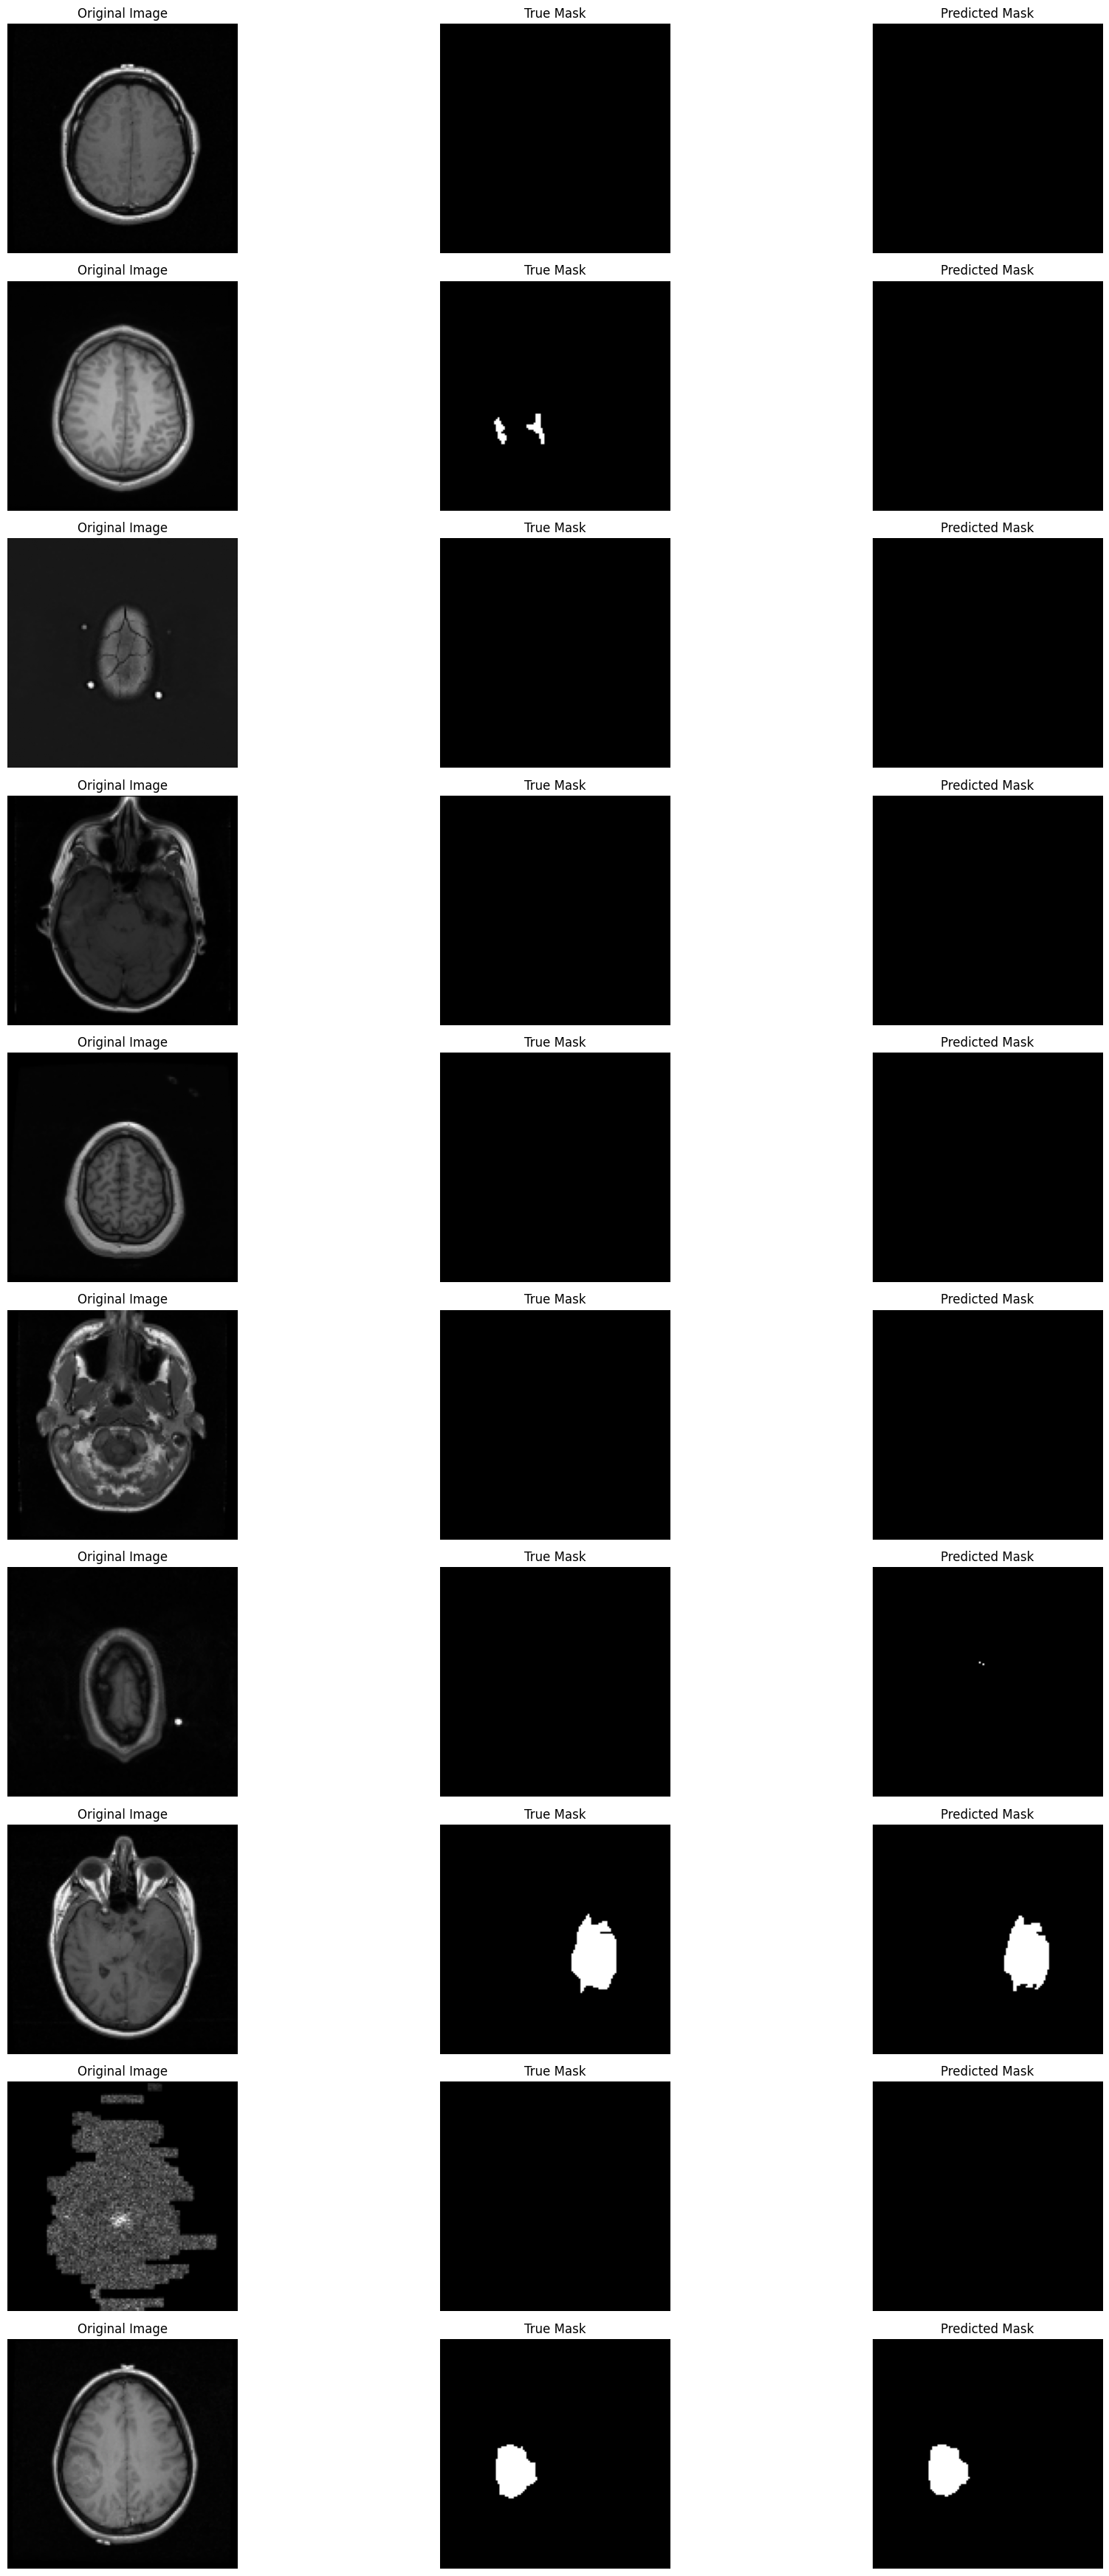

In [ ]:
plt.figure(figsize=(20, 35))
for i in range(10):
    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(test_images[i][..., 0], cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(binary_preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test IOU: {results[2]}")
print(f"Test Dice Coefficient: {results[3]}")
print(f"Test Sensitivity: {results[4]}")
print(f"Test Specificity: {results[5]}")
print(f"Test False Negative Proportion: {results[6]}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 347ms/step - accuracy: 0.9984 - dice_coefficient: 0.8905 - false_negative_proportion: 0.0946 - iou: 0.8475 - loss: 0.0052 - sensitivity: 0.9054 - specificity: 0.9992
Test Loss: 0.005289188586175442
Test Accuracy: 0.998296320438385
Test IOU: 0.8344225883483887
Test Dice Coefficient: 0.8754192590713501
Test Sensitivity: 0.8932693600654602
Test Specificity: 0.999245285987854
Test False Negative Proportion: 0.10673066228628159


In [ ]:
results_val = model.evaluate(val_ds)
print(f"Val Loss: {results_val[0]}")
print(f"Val Accuracy: {results_val[1]}")
print(f"Val IOU: {results_val[2]}")
print(f"Val Dice Coefficient: {results_val[3]}")
print(f"Val Sensitivity: {results_val[4]}")
print(f"Val Specificity: {results_val[5]}")
print(f"Val False Negative Proportion: {results_val[6]}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.9981 - dice_coefficient: 0.8942 - false_negative_proportion: 0.0990 - iou: 0.8488 - loss: 0.0049 - sensitivity: 0.9010 - specificity: 0.9993
Val Loss: 0.004254758358001709
Val Accuracy: 0.998346745967865
Val IOU: 0.8487045168876648
Val Dice Coefficient: 0.8944151401519775
Val Sensitivity: 0.9034363031387329
Val Specificity: 0.9993671178817749
Val False Negative Proportion: 0.09656375646591187


In [ ]:
results_train = model.evaluate(train_ds)
print(f"Train Loss: {results_train[0]}")
print(f"Train Accuracy: {results_train[1]}")
print(f"Train IOU: {results_train[2]}")
print(f"Train Dice Coefficient: {results_train[3]}")
print(f"Train Sensitivity: {results_train[4]}")
print(f"Train Specificity: {results_train[5]}")
print(f"Train False Negative Proportion: {results_train[6]}")

197/197 ━━━━━━━━━━━━━━━━━━━━ 66s 334ms/step - accuracy: 0.9985 - dice_coefficient: 0.9065 - false_negative_proportion: 0.0730 - iou: 0.8830 - loss: 0.0034 - sensitivity: 0.9270 - specificity: 0.9993
Train Loss: 0.00318397325463593
Train Accuracy: 0.9986474514007568
Train IOU: 0.8866895437240601
Train Dice Coefficient: 0.9094425439834595
Train Sensitivity: 0.9301912188529968
Train Specificity: 0.9993875026702881
Train False Negative Proportion: 0.06980905681848526


As you can see below, the results are much better than the TransUNet and kinf of similar to the original model but there are some slight improvements.

In [ ]:
data = {
    'Metric': ['Loss', 'Accuracy', 'Dice Coefficient', 'Sensitivity', 'Specificity', 'False Negative Proportion'],
    'Train': [results_train[0], results_train[1], results_train[3], results_train[4], results_train[5], results_train[6]],
    'Validation': [results_val[0], results_val[1], results_val[3], results_val[4], results_val[5], results_val[6]],
    'Test': [results[0], results[1], results[3], results[4], results[5], results[6]]
}

df_results = pd.DataFrame(data)

df_results

Metric     Train  Validation      Test
0                       Loss  0.003184    0.004255  0.005289
1                   Accuracy  0.998647    0.998347  0.998296
2           Dice Coefficient  0.909443    0.894415  0.875419
3                Sensitivity  0.930191    0.903436  0.893269
4                Specificity  0.999388    0.999367  0.999245
5  False Negative Proportion  0.069809    0.096564  0.106731